In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'
ele_path='//weili/User2/mxsun/CESS_230818/elephant_active_area/IUCN/'

# prepare data

In [55]:
#--------------------elephant density---------------------------------------
# check the Δ dem and Δ slope distribution
dem1=np.load(drv_path+'pattern-drivers_DEAA_dem_0.25deg_240506.npy',allow_pickle=True)
dem2=np.load(drv_path+'pattern-drivers_DAA_dem_0.25deg_240506.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'pattern-drivers_DEAA_slope_0.25deg_240506.npy',allow_pickle=True)
slo2=np.load(drv_path+'pattern-drivers_DAA_slope_0.25deg_240506.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

# Add mean paras
res_name=['ndvi_res','csif_res','treeH','tc','lst','et','albedo','spei']
delta=[]
for i in range(8):
    f1=np.load(drv_path+'pattern-drivers_DEAA_{}_0.25deg_240506.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'pattern-drivers_DAA_{}_0.25deg_240506.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    if i < 7:
        ff=f1-f2
        delta.append(ff)
    else:
        ff=(f1+f2)/2
        delta.append(ff)
dens_a=np.load(drv_path+'pattern-drivers_DEAA_dens_0.25deg_240506.npy',allow_pickle=True)*dd_mask
delta.append(dens_a)
len(delta)

9

In [56]:
# 每一层数据位置对应,建立mask,使得每一层有效数值位置对应
dd=np.copy(delta)
dd[~np.isnan(dd)]=1
cc_mask=np.ones((260,316))
for i in range(9):
    cc_mask=cc_mask*dd[i]

delta_dd=np.copy(delta)
for i in range(9):
    delta_dd[i]=delta[i]*cc_mask
    print(np.count_nonzero(~np.isnan(delta_dd[i])))

2651
2651
2651
2651
2651
2651
2651
2651
2651


In [58]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a
pd_delta=[]
for i in range(9):
    pd_delta.append(kill_nan(delta_dd[i]))
#['ndvi_res','csif_res','treeH','tc','lst','et','albedo','spei']
pd_delta=list(map(list, zip(*pd_delta)))#list转置
df=pd.DataFrame(pd_delta,columns=['NDVI_res','SIF_res','TH','TC','LST','ET','Albedo','SPEI_m','Ele_Dens'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NDVI_res  2651 non-null   float64
 1   SIF_res   2651 non-null   float64
 2   TH        2651 non-null   float64
 3   TC        2651 non-null   float64
 4   LST       2651 non-null   float64
 5   ET        2651 non-null   float64
 6   Albedo    2651 non-null   float64
 7   SPEI_m    2651 non-null   float64
 8   Ele_Dens  2651 non-null   float64
dtypes: float64(9)
memory usage: 186.5 KB


In [59]:
df.to_csv(drv_path+'path_analysis_240506.csv',header=True,index=True)

# scatter fig

## 控制LST,计算TH和ndvi_res 的偏相关关系

In [2]:
df=pd.read_csv(drv_path+'path_analysis_240506.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2651 non-null   int64  
 1   NDVI_res    2651 non-null   float64
 2   SIF_res     2651 non-null   float64
 3   TH          2651 non-null   float64
 4   TC          2651 non-null   float64
 5   LST         2651 non-null   float64
 6   ET          2651 non-null   float64
 7   Albedo      2651 non-null   float64
 8   SPEI_m      2651 non-null   float64
 9   Ele_Dens    2651 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 207.2 KB


In [3]:
#回归残差求偏相关系数
import statsmodels.api as sm
from statsmodels.formula.api import ols
#control=['SPEI','Precipitation',['SPEI','Precipitation'],'dif_LST',['dif_LST','SPEI'],['dif_LST','Precipitation'],['dif_LST','SPEI','Precipitation']]
#控制变量LST
th_lst=sm.OLS(df['TH'],df['TC']).fit()
tc_lst=sm.OLS(df['TC'],df['LST']).fit()
NDVIres_lst=sm.OLS(df['NDVI_res'],df['LST']).fit()
CSIFres_lst=sm.OLS(df['SIF_res'],df['LST']).fit()

In [4]:
res_tree=[df['TH'],th_lst.resid,df['TC'],tc_lst.resid]
res_res=[df['NDVI_res'],df['SIF_res']]
res_redius=[NDVIres_lst.resid,CSIFres_lst.resid]

In [5]:
stats.spearmanr(df['TH'],df['SIF_res'])

SpearmanrResult(correlation=0.06469569022411023, pvalue=0.0008592613661618177)

## fig scatter

In [7]:
stats.spearmanr(th_lst.resid,CSIFres_lst.resid)

SpearmanrResult(correlation=-0.008365443028482222, pvalue=0.6668151105183655)

C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


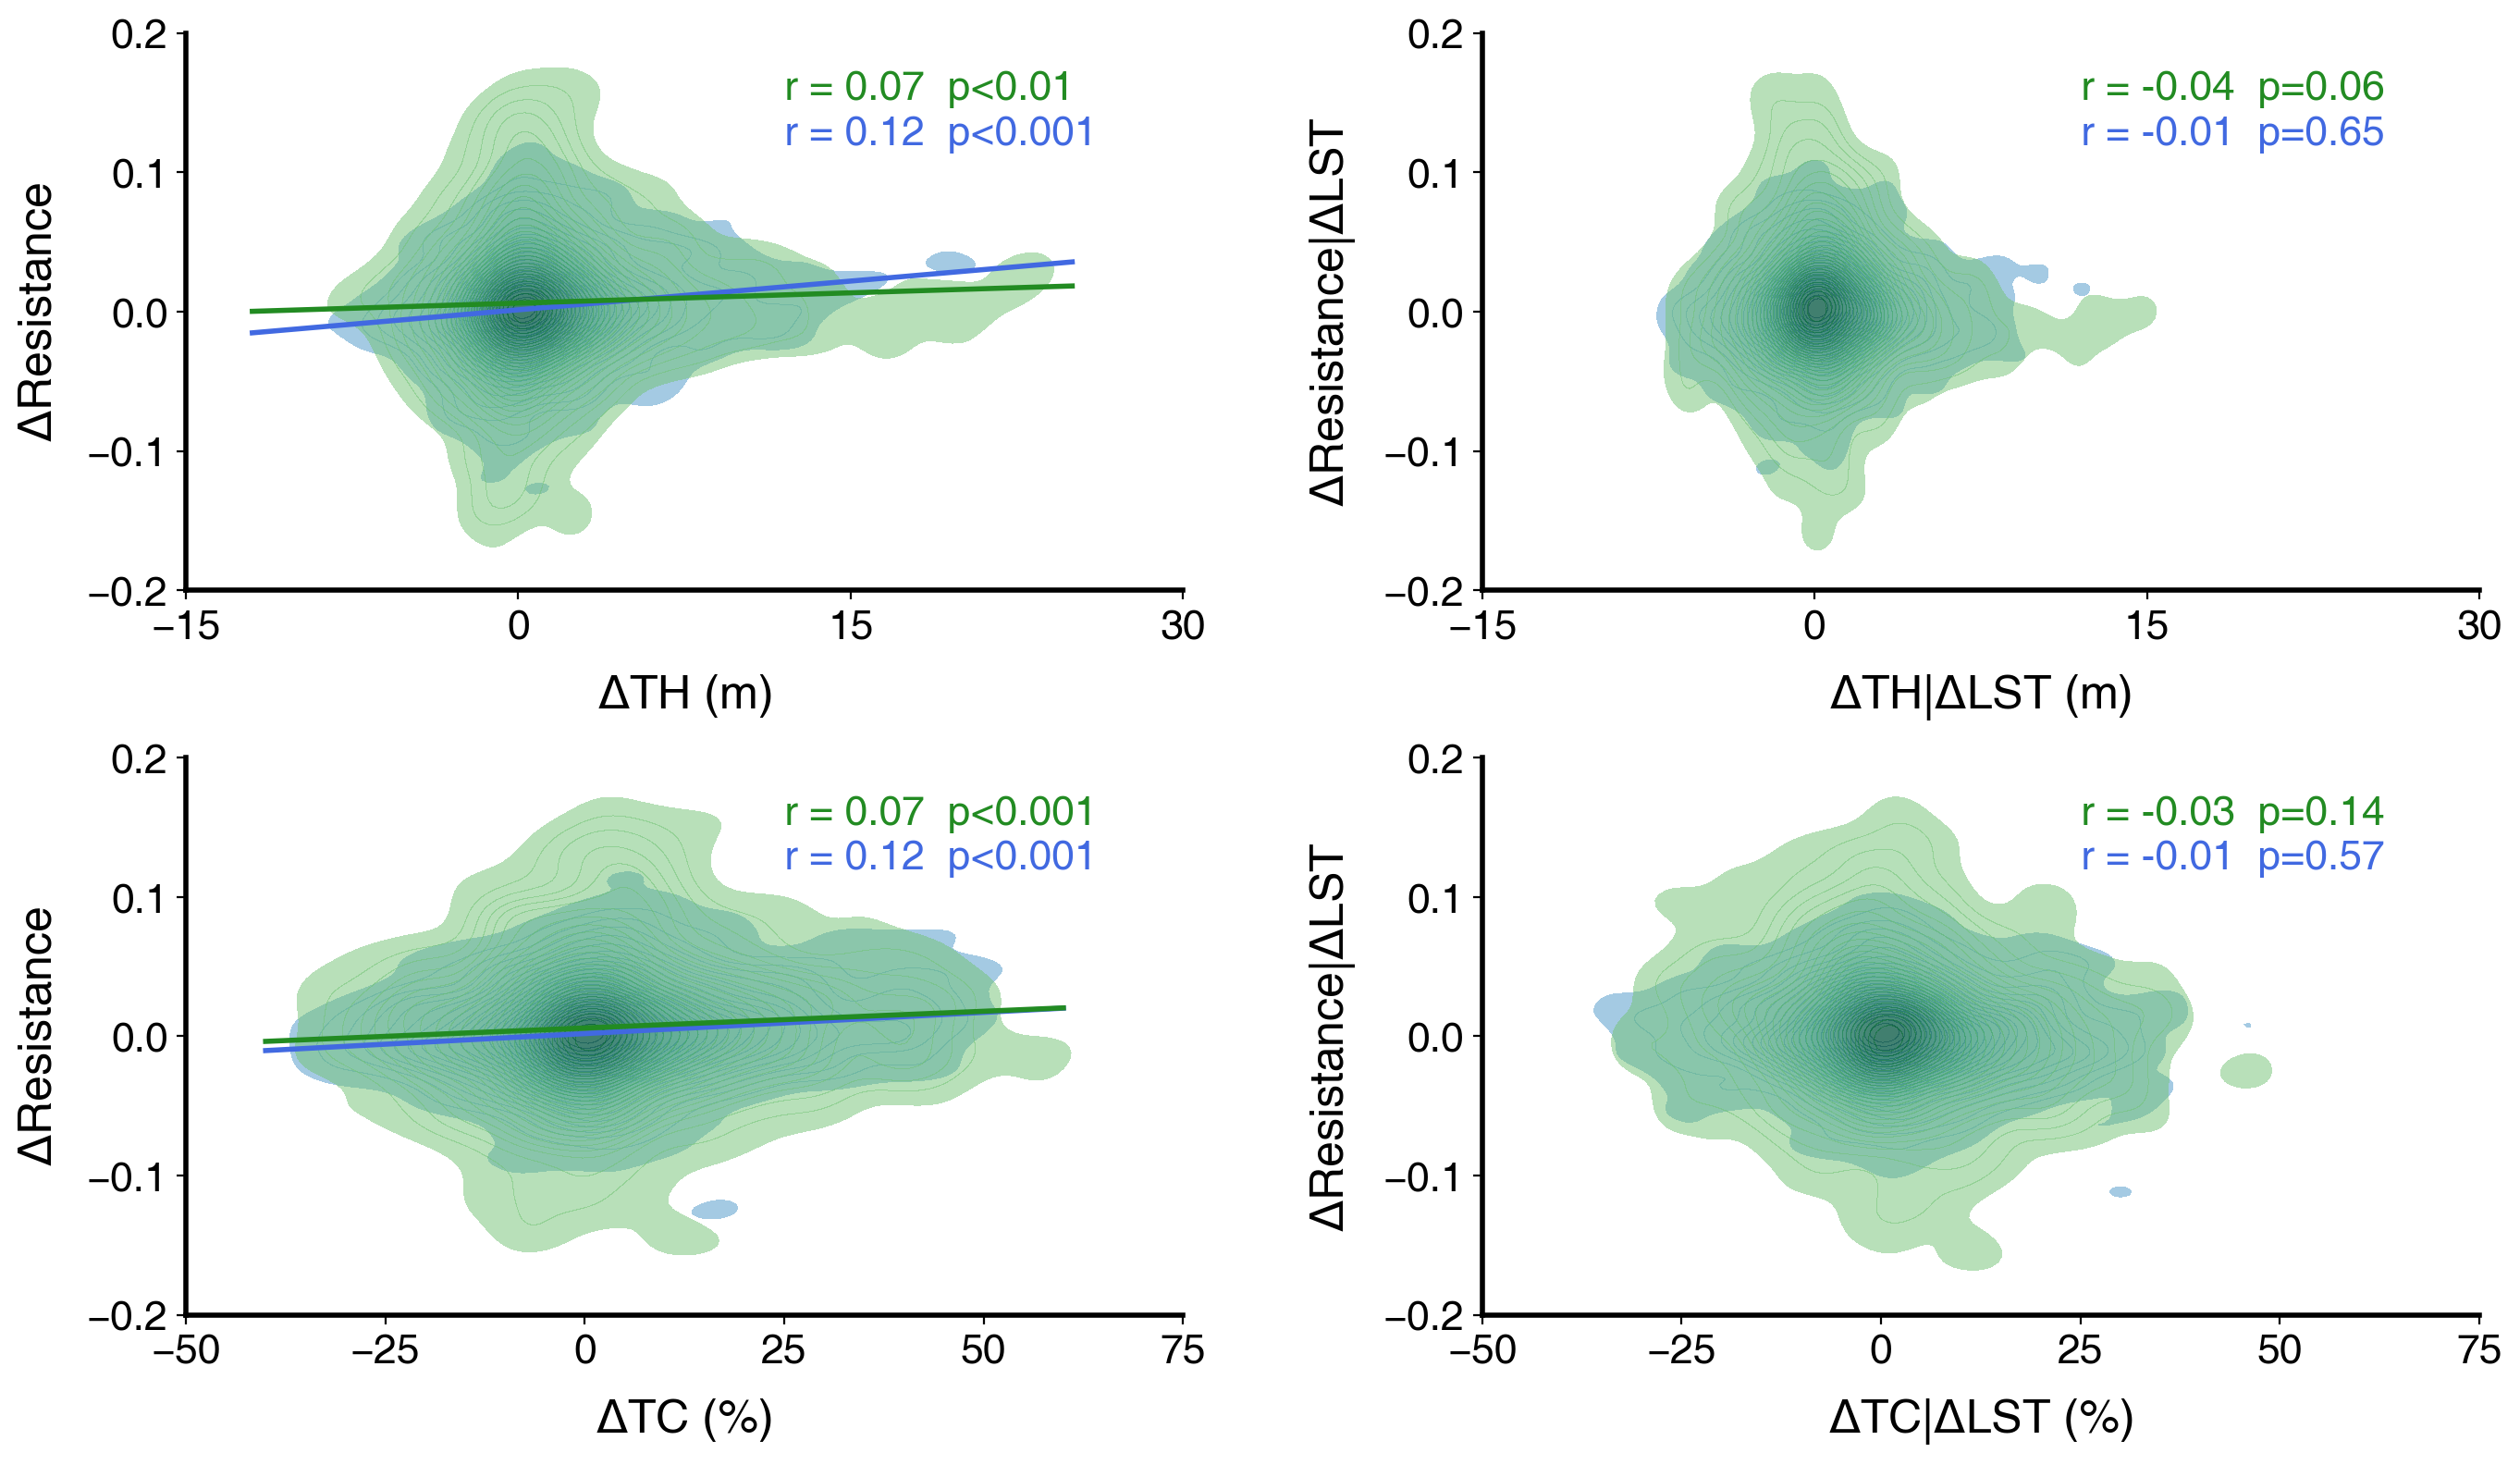

In [8]:
import scipy
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
import matplotlib.colors as colors
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
from matplotlib.gridspec import GridSpec     # 利用网格确定图形的位置

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(16,9)) ##width, height default(8,6)
fig.subplots_adjust(wspace=0.3,hspace=0.3, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs

cl=['royalblue','forestgreen']
mark=['*','.']
lab_x=['$Δ$TH (m)','$Δ$TH|$Δ$LST (m)','$Δ$TC (%)','$Δ$TC|$Δ$LST (%)']
lab_y=['$Δ$Resistance','$Δ$Resistance|$Δ$LST','$Δ$Resistance','$Δ$Resistance|$Δ$LST']
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
trunc_cmap = [truncate_colormap(plt.get_cmap("Blues"), 0.6, 1),truncate_colormap(plt.get_cmap("Greens"), 0.5, 0.9)]
cov=[[],'LST',[],'LST']
x_a=['TH','TH','TC','TC']
y_a=['NDVI_res','SIF_res']
for i in range(4):
    ax=fig.add_subplot(2,2,i+1)
    if i<=1:
        xx=np.linspace(-12,25,1000)
        ax.set_ylim(-0.2,0.2)
        ax.set_yticks(np.arange(-0.2,0.201,0.1))
        ax.set_xlim(-15,30)
        ax.set_xticks(np.arange(-15,30.1,15))
    else:
        xx=np.linspace(-40,60,1000)
        ax.set_ylim(-0.2,0.2)
        ax.set_yticks(np.arange(-0.2,0.201,0.1))
        ax.set_xlim(-50,75)
        ax.set_xticks(np.arange(-50,75.1,25))
    for j in range(2):
        if i==0 or i==2:
            kde_plot = sns.kdeplot(x=res_tree[i], y=res_res[j], cmap=trunc_cmap[j], alpha=0.5,fill=True,ax=ax,levels=30, thresh=0.04)
            poly=np.polyfit(x=res_tree[i], y=res_res[j],deg=1)#一元二次方程拟合,,w=count[i]
            y_value=np.polyval(poly,xx)
            yfit=np.polyval(poly,res_res[j])
            cor=pg.partial_corr(data=df,x=x_a[i],y=y_a[j],covar=cov[i],method='spearman').round(3)['r']
            p_value=pg.partial_corr(data=df,x=x_a[i],y=y_a[j],covar=cov[i],method='spearman').round(3)['p-val']
            #print(p_value)
            if p_value[0]<0.001:
                ax.plot(xx,y_value,color=cl[j],linewidth=2)
                #cor,p_value = scipy.stats.spearmanr(res_tree[i],res_res[j])
                ax.text(0.6,0.8+0.08*j,'r = {:.2f}  p<0.001'.format(cor[0]), transform = ax.transAxes,color=cl[j])
            elif p_value[0]<0.01:
                ax.plot(xx,y_value,color=cl[j],linewidth=2)
                #cor,p_value = scipy.stats.spearmanr(res_tree[i],res_res[j])
                ax.text(0.6,0.8+0.08*j,'r = {:.2f}  p<0.01'.format(cor[0]), transform = ax.transAxes,color=cl[j])
            elif p_value[0]<0.05:
                ax.plot(xx,y_value,color=cl[j],linewidth=2)
                #cor,p_value = scipy.stats.spearmanr(res_tree[i],res_res[j])
                ax.text(0.6,0.8+0.08*j,'r = {:.2f}  p<0.05'.format(cor[0]), transform = ax.transAxes,color=cl[j])
            elif p_value[0]>=0.05:
                #cor,p_value = scipy.stats.spearmanr(res_tree[i],res_res[j])
                ax.text(0.6,0.8+0.08*j,'r = {:.2f}  p={:.2f}'.format(cor[0],p_value[0]), transform = ax.transAxes,color=cl[j])
        if i==1 or i==3:
            kde_plot1 = sns.kdeplot(x=res_tree[i], y=res_redius[j], cmap=trunc_cmap[j], alpha=0.5,fill=True,ax=ax,levels=30, thresh=0.04)
            poly1=np.polyfit(x=res_tree[i], y=res_redius[j],deg=1)#一元二次方程拟合,,w=count[i]
            y_value1=np.polyval(poly1,xx)
            yfit1=np.polyval(poly1,res_redius[j])
            #ax.plot(xx,y_value1,color=cl[j],linestyle='--',linewidth=2)
            cor=df.partial_corr(x=x_a[i],y=y_a[j],covar=cov[i],method='spearman').round(3)['r']
            p_value=df.partial_corr(x=x_a[i],y=y_a[j],covar=cov[i],method='spearman').round(3)['p-val']
            #cor1,p_value1 = scipy.stats.spearmanr(res_tree[i],res_redius[j])
            if p_value[0]<0.001:
                #ax.plot(xx,y_value1,color=cl[j],linewidth=2)
                #cor,p_value = scipy.stats.spearmanr(res_tree[i],res_res[j])
                ax.text(0.6,0.8+0.08*j,'r = {:.2f}  p<0.001'.format(cor[0]), transform = ax.transAxes,color=cl[j])
            elif p_value[0]<0.01:
                #ax.plot(xx,y_value1,color=cl[j],linewidth=2)
                #cor,p_value = scipy.stats.spearmanr(res_tree[i],res_res[j])
                ax.text(0.6,0.8+0.08*j,'r = {:.2f}  p<0.01'.format(cor[0]), transform = ax.transAxes,color=cl[j])
            elif p_value[0]<0.05:
                #ax.plot(xx,y_value1,color=cl[j],linewidth=2)
                #cor,p_value = scipy.stats.spearmanr(res_tree[i],res_res[j])
                ax.text(0.6,0.8+0.08*j,'r = {:.2f}  p<0.05'.format(cor[0]), transform = ax.transAxes,color=cl[j])
            elif p_value[0]>=0.05:
                #ax.plot(xx,y_value1,color=cl[j],linestyle='--',linewidth=2)
                #cor,p_value = scipy.stats.spearmanr(res_tree[i],res_res[j])
                ax.text(0.6,0.8+0.08*j,'r = {:.2f}  p={:.2f}'.format(cor[0],p_value[0]), transform = ax.transAxes,color=cl[j])
    
    ax.set_xlabel(lab_x[i],size=18,labelpad=10)
    ax.set_ylabel(lab_y[i],size=18,labelpad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/ReviseV4/Fig4a_d.tif", dpi=600, bbox_inches = 'tight')

## fig scatter1

In [10]:
cor=pg.partial_corr(data=df,x='TC',y='NDVI_res',covar='LST',method='spearman').round(3)
p_value=pg.partial_corr(data=df,x='TC',y='NDVI_res',covar='LST',method='spearman').round(3)['p-val']
cor

,n,r,CI95%,p-val
spearman,2651,-0.011,"[-0.05, 0.03]",0.574


In [11]:
pg.partial_corr(data=df,x='TH',y=y_a[0],covar='LST',method='spearman').round(3)

,n,r,CI95%,p-val
spearman,2651,-0.009,"[-0.05, 0.03]",0.647


In [54]:
??pg.partial_corr

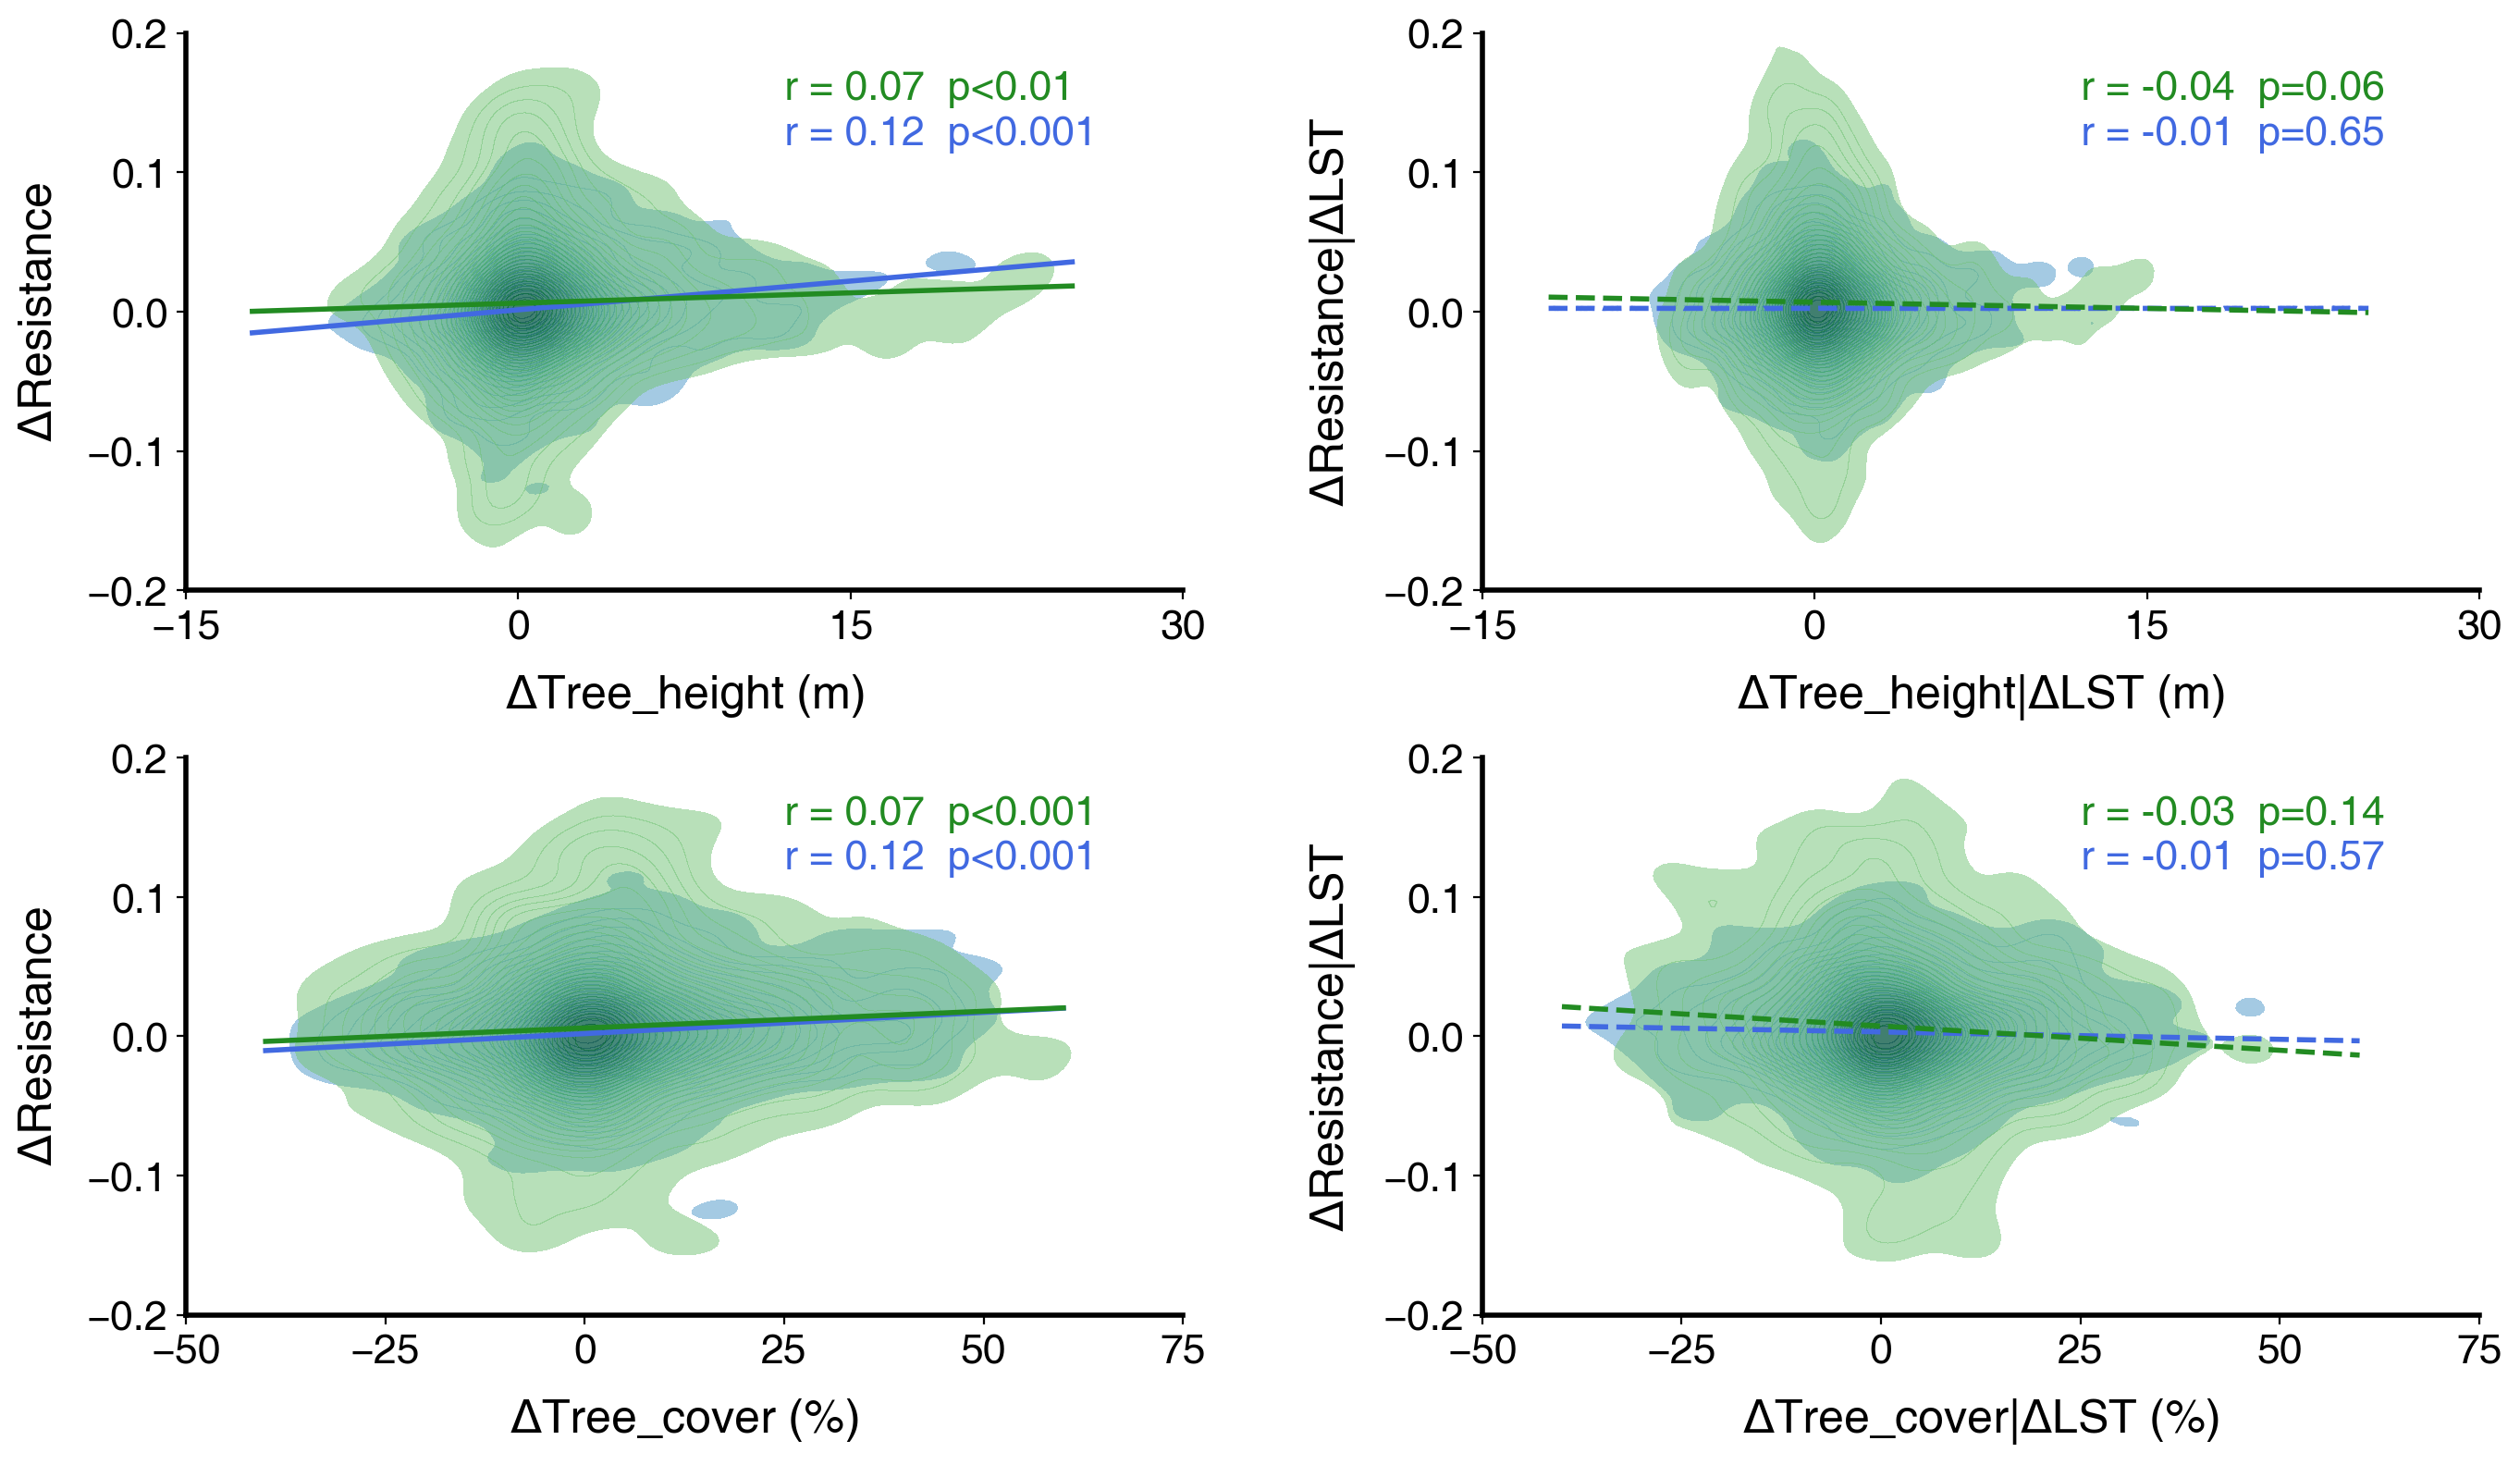

In [13]:
import scipy
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
import matplotlib.colors as colors
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
from matplotlib.gridspec import GridSpec     # 利用网格确定图形的位置

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(16,9)) ##width, height default(8,6)
fig.subplots_adjust(wspace=0.3,hspace=0.3, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs

cl=['royalblue','forestgreen']
mark=['*','.']
lab_x=['$Δ$Tree_height (m)','$Δ$Tree_height|$Δ$LST (m)','$Δ$Tree_cover (%)','$Δ$Tree_cover|$Δ$LST (%)']
lab_y=['$Δ$Resistance','$Δ$Resistance|$Δ$LST','$Δ$Resistance','$Δ$Resistance|$Δ$LST']
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
trunc_cmap = [truncate_colormap(plt.get_cmap("Blues"), 0.6, 1),truncate_colormap(plt.get_cmap("Greens"), 0.5, 0.9)]
cov=[[],'LST',[],'LST']
x_a=['TH','TH','TC','TC']
y_a=['NDVI_res','SIF_res']
for i in range(4):
    ax=fig.add_subplot(2,2,i+1)
    if i<=1:
        xx=np.linspace(-12,25,2651)
        ax.set_ylim(-0.2,0.2)
        ax.set_yticks(np.arange(-0.2,0.201,0.1))
        ax.set_xlim(-15,30)
        ax.set_xticks(np.arange(-15,30.1,15))
    else:
        xx=np.linspace(-40,60,2651)
        ax.set_ylim(-0.2,0.2)
        ax.set_yticks(np.arange(-0.2,0.201,0.1))
        ax.set_xlim(-50,75)
        ax.set_xticks(np.arange(-50,75.1,25))
    for j in range(2):
        kde_plot = sns.kdeplot(x=res_tree[i], y=res_res[j], cmap=trunc_cmap[j], alpha=0.5,fill=True,ax=ax,levels=30, thresh=0.04)
        poly=np.polyfit(x=res_tree[i], y=res_res[j],deg=1)#一元二次方程拟合,w=count[i]
        y_value=np.polyval(poly,xx)
        yfit=np.polyval(poly,res_res[j])
        cor=pg.partial_corr(data=df,x=x_a[i],y=y_a[j],covar=cov[i],method='spearman').round(3)['r']
        p_value=pg.partial_corr(data=df,x=x_a[i],y=y_a[j],covar=cov[i],method='spearman').round(3)['p-val']
        #print(p_value)
        if p_value[0]<0.001:
            ax.plot(xx,y_value,color=cl[j],linewidth=2)
            #cor,p_value = scipy.stats.spearmanr(res_tree[i],res_res[j])
            ax.text(0.6,0.8+0.08*j,'r = {:.2f}  p<0.001'.format(cor[0]), transform = ax.transAxes,color=cl[j])
        elif p_value[0]<0.01:
            ax.plot(xx,y_value,color=cl[j],linewidth=2)
            ax.text(0.6,0.8+0.08*j,'r = {:.2f}  p<0.01'.format(cor[0]), transform = ax.transAxes,color=cl[j])
        elif p_value[0]<0.05:
            ax.plot(xx,y_value,color=cl[j],linewidth=2)
            ax.text(0.6,0.8+0.08*j,'r = {:.2f}  p<0.05'.format(cor[0]), transform = ax.transAxes,color=cl[j])
        elif p_value[0]>=0.05:
            if j==0 and i==1:
                ax.plot(xx,yfit,color=cl[j],linewidth=2,linestyle='--')
            else:
                ax.plot(xx,y_value,color=cl[j],linewidth=2,linestyle='--')
            ax.text(0.6,0.8+0.08*j,'r = {:.2f}  p={:.2f}'.format(cor[0],p_value[0]), transform = ax.transAxes,color=cl[j])            
    ax.set_xlabel(lab_x[i],size=18,labelpad=10)
    ax.set_ylabel(lab_y[i],size=18,labelpad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/ReviseV4/Fig4a_d.tif", dpi=600, bbox_inches = 'tight')

# SI 补充

In [66]:
#无控制
a=pg.partial_corr(data=df, x='TH', y='NDVI_res', covar=[],method='spearman').round(3)
b=pg.partial_corr(data=df, x='TC', y='NDVI_res', covar=[],method='spearman').round(3)
c=pg.partial_corr(data=df, x='TH', y='SIF_res', covar=[],method='spearman').round(3)
d=pg.partial_corr(data=df, x='TC', y='SIF_res', covar=[],method='spearman').round(3)
a,b,c,d

(             n      r         CI95%  p-val
 spearman  2651  0.118  [0.08, 0.16]    0.0,
              n      r         CI95%  p-val
 spearman  2651  0.116  [0.08, 0.15]    0.0,
              n      r        CI95%  p-val
 spearman  2651  0.065  [0.03, 0.1]  0.001,
              n     r         CI95%  p-val
 spearman  2651  0.07  [0.03, 0.11]    0.0)

# 控制SPEI

In [68]:
#控制SPEI
a=pg.partial_corr(data=df, x='TH', y='NDVI_res', covar=['SPEI_m'],method='spearman').round(3)
b=pg.partial_corr(data=df, x='TC', y='NDVI_res', covar=['SPEI_m'],method='spearman').round(3)
c=pg.partial_corr(data=df, x='TH', y='SIF_res', covar=['SPEI_m'],method='spearman').round(3)
d=pg.partial_corr(data=df, x='TC', y='SIF_res', covar=['SPEI_m'],method='spearman').round(3)
a,b,c,d

(             n      r         CI95%  p-val
 spearman  2651  0.123  [0.08, 0.16]    0.0,
              n      r         CI95%  p-val
 spearman  2651  0.118  [0.08, 0.16]    0.0,
              n      r         CI95%  p-val
 spearman  2651  0.077  [0.04, 0.11]    0.0,
              n      r         CI95%  p-val
 spearman  2651  0.076  [0.04, 0.11]    0.0)

In [69]:
#控制LST
a=pg.partial_corr(data=df, x='TH', y='NDVI_res', covar=['LST'],method='spearman').round(3)
b=pg.partial_corr(data=df, x='TC', y='NDVI_res', covar=['LST'],method='spearman').round(3)
c=pg.partial_corr(data=df, x='TH', y='SIF_res', covar=['LST'],method='spearman').round(3)
d=pg.partial_corr(data=df, x='TC', y='SIF_res', covar=['LST'],method='spearman').round(3)
a,b,c,d

(             n      r          CI95%  p-val
 spearman  2651 -0.009  [-0.05, 0.03]  0.647,
              n      r          CI95%  p-val
 spearman  2651 -0.011  [-0.05, 0.03]  0.574,
              n      r         CI95%  p-val
 spearman  2651 -0.036  [-0.07, 0.0]  0.064,
              n      r          CI95%  p-val
 spearman  2651 -0.029  [-0.07, 0.01]   0.14)

In [70]:
#控制LST & SPEI
a=pg.partial_corr(data=df, x='TH', y='NDVI_res', covar=['LST','SPEI_m'],method='spearman').round(3)
b=pg.partial_corr(data=df, x='TC', y='NDVI_res', covar=['LST','SPEI_m'],method='spearman').round(3)
c=pg.partial_corr(data=df, x='TH', y='SIF_res', covar=['LST','SPEI_m'],method='spearman').round(3)
d=pg.partial_corr(data=df, x='TC', y='SIF_res', covar=['LST','SPEI_m'],method='spearman').round(3)
a,b,c,d

(             n      r          CI95%  p-val
 spearman  2651 -0.005  [-0.04, 0.03]  0.778,
              n      r          CI95%  p-val
 spearman  2651 -0.009  [-0.05, 0.03]  0.643,
              n      r          CI95%  p-val
 spearman  2651 -0.022  [-0.06, 0.02]  0.261,
              n      r          CI95%  p-val
 spearman  2651 -0.021  [-0.06, 0.02]  0.289)